In [1]:
import numpy as np
import imageio.v2 as imageio
from io import BytesIO
from tqdm import trange
from pyhdf.SD import SD, SDC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def read_hdf(path, is_init):
    f = SD(path, SDC.READ)
    arr = f.select("Data-Set-2").get()
    dim0 = f.select("fakeDim0").get()
    dim1 = f.select("fakeDim1").get()
    if is_init:
        return arr, dim0, dim1
    dim2 = f.select("fakeDim2").get()
    return arr, dim0, dim1, dim2
    

In [3]:
data, i, j, k = read_hdf('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/cr1751/kpo_mas_mas_std_0101/br002.hdf', False)

In [4]:
bc, i_bc, j_bc = read_hdf('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/cr1751/kpo_mas_mas_std_0101/br_r0.hdf', True)

In [5]:
i.shape, j.shape, k.shape, data.shape, i_bc.shape, j_bc.shape, bc.shape

((128,), (110,), (141,), (128, 110, 141), (128,), (100,), (128, 100))

In [6]:
j_bc

array([0.        , 0.04316993, 0.08607038, 0.12851126, 0.17040162,
       0.21171659, 0.25245765, 0.2926322 , 0.3322481 , 0.37131312,
       0.40983495, 0.44782108, 0.48527902, 0.5222161 , 0.5586395 ,
       0.5945565 , 0.629974  , 0.66489905, 0.69933844, 0.73329896,
       0.7667872 , 0.7998098 , 0.8323732 , 0.8644838 , 0.89614785,
       0.9273716 , 0.95816123, 0.9885227 , 1.018462  , 1.047985  ,
       1.0770974 , 1.1058049 , 1.1341134 , 1.1620282 , 1.1895548 ,
       1.2166986 , 1.2434651 , 1.2698592 , 1.2958864 , 1.3215517 ,
       1.34686   , 1.3718165 , 1.396426  , 1.4206932 , 1.4446229 ,
       1.46822   , 1.4914902 , 1.5144461 , 1.5371224 , 1.5595967 ,
       1.5819961 , 1.6044703 , 1.6271465 , 1.6501024 , 1.6733726 ,
       1.6969697 , 1.7208996 , 1.7451668 , 1.7697762 , 1.7947326 ,
       1.820041  , 1.8457062 , 1.8717334 , 1.8981277 , 1.9248941 ,
       1.9520379 , 1.9795645 , 2.0074792 , 2.0357876 , 2.0644953 ,
       2.0936077 , 2.1231306 , 2.15307   , 2.1834314 , 2.21422

In [7]:
rot = 80
data = np.concatenate((data[rot:], data[:rot]), axis=0)

In [10]:
def plot_3d_points(data, i, j, k, k_idx):
    """
    Plots a 3D scatter plot of (x, y, z) points with intensity as color.
    
    Args:
        points (numpy.ndarray): Array of shape (n, 4) containing (x, y, z, intensity).
    """
    frames = []
    for rot in trange(128):
        intensity = np.concatenate((data[rot:, :, :], data[:rot, :, :]), axis=0)
        
        theta, phi = np.meshgrid(i, j, indexing='ij')  # Shape (128, 110)
        
        r = k[k_idx]  # Select single radius value

        # Convert spherical (r, theta, phi) to Cartesian (x, y, z)
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)

        # Flatten everything
        x_flat = x.ravel()
        y_flat = y.ravel()
        z_flat = z.ravel()
        intensity_flat = intensity[:, :, k_idx].ravel()  # Select the corresponding intensity slice

        # Stack into (n, 4) array
        points = np.column_stack((x_flat, y_flat, z_flat, intensity_flat))
        
        x, y, z, intensity = points[:, 0], points[:, 1], points[:, 2], points[:, 3]

        fig = plt.figure(figsize=(10, 7), tight_layout=True)
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot with intensity as color
        sc = ax.scatter(x, y, z, c=intensity, cmap='jet_r', marker='o')

        # Add color bar
        cbar = plt.colorbar(sc, ax=ax, pad=0.01, shrink=0.8, aspect=20)
        cbar.set_label('Intensity')

        ax.set_xlabel('X', labelpad=0)
        ax.set_ylabel('Y', labelpad=0)
        ax.set_zlabel('Z', labelpad=0)
        ax.set_title(f'br002 at k={k_idx}', pad=5)
        
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove extra margins

        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(imageio.imread(buf))
        plt.close()
        buf.close()
    return frames


In [11]:
frames = plot_3d_points(data, i, j, k, 70)

100%|██████████| 128/128 [00:46<00:00,  2.73it/s]


In [12]:
video_path = "point_cloud.gif"
imageio.mimsave(video_path, frames, fps=20)

print(f"Video saved as {video_path}")

Video saved as point_cloud.gif


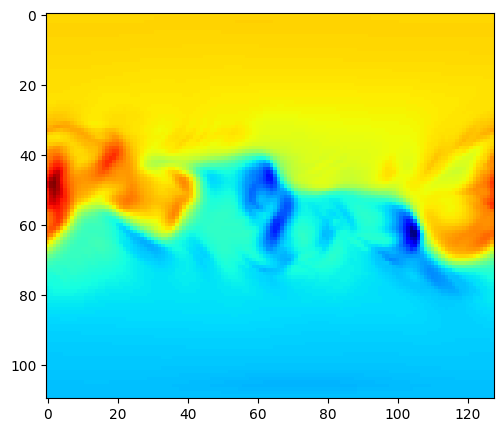

In [6]:
plt.figure(figsize=(7,5))
plt.imshow(data[:, :, 70].transpose(1, 0), cmap='jet_r')